In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import ndpretty

import data_prep
import gnn_prep
from gnn_prep import Experiment
from ensemble import ensemblify, deep_ensemblify
import widget_util

import plotly.graph_objects as go
import plotly.express as px
import itertools

In [2]:
ndpretty.default()

# Analyse experiment results

In [3]:
def plot_results(ground_truth, exps, selected_exps, device, date_range, feature, events):
    plt.figure(figsize=(10,5))

    # plot events
    for event in events:
        plt.axvspan(event.start, event.end, color=event.color, alpha=0.1, label=event.name)

    # plot ground truth
    (start, end) = date_range
    y = ground_truth[(ground_truth['device_id'] == device) & (ground_truth['time'] >= start) & (ground_truth['time'] < end)]
    plt.plot(y['time'], y[feature], label='ground truth')

    # plot experiment predictions
    for e in selected_exps:
        exp = exps[e]
        df = exp.preds
        y = df[(df['device_id'] == device) & (df['time'] >= start) & (df['time'] < end)]
        plt.plot(y['time'], y[feature], label=e)

    plt.tight_layout()
    plt.title(f"{feature} @ {device}")
    plt.legend(loc='upper left')
    axes = plt.gca()
    axes.set_xlim([start,end])
    plt.show()

    # plot R values for device
    for e in selected_exps:
        R_in, R_out = exps[e].R_in, exps[e].R_out
        if R_in is not None and R_out is not None:
            R_in[device].plot(kind='area', title=f"R_in for {e} @ {device}")
            R_out[device].plot(kind='area', title=f"R_out for {e} @ {device}")

In [4]:
gnn_data_path="Previous work/PM2.5-GNN/data/"
gnn_experiment_path = gnn_data_path + "results/"

## Device-level data set ("old", `DS2`)

In [5]:
dataset_name = "DS2"

data = data_prep.load_beijing_data()

devices_path = f"{gnn_data_path}city_{dataset_name}.txt"
city_txt = pd.read_csv(devices_path, sep=' ', header=None, index_col=0)
devices = list(city_txt[1])


Loaded air quality data from 87 devices. No weather data for []


In [6]:
start_date = "2020-12-11 01:00:00"
end_date = "2020-12-31 01:00:00"

exp_paths = {
    # **{"SGNN3_0_72_%02d" % i: "0_72/1/SplitGNN_3/2021-05-04_19-23-53/%02d/" % i for i in range(5)},
    # **{"SGNN3.2_0_72_%02d" % i: "0_72/1/SplitGNN_3_2/2021-05-04_19-22-50/%02d/" % i for i in range(5)},
    # **{"PM25_GNN_0_72_%02d" % i: "0_72/1/PM25_GNN/2021-05-04_19-24-55/%02d/" % i for i in range(5)},
    **{"SGNN3_1_72_%02d" % i: "1_72/1/SplitGNN_3/2021-05-05_08-19-25/%02d/" % i for i in range(5)}, 
    **{"SGNN3.2_1_72_%02d" % i: "1_72/1/SplitGNN_3_2/2021-05-05_08-20-45/%02d/" % i for i in range(5)},
    **{"SGNN4_1_72_%02d" % i: "1_72/1/TransferModel/2021-05-11_20-12-21/%02d/" % i for i in range(5)},
    **{"PM25_GNN_1_72_%02d" % i: "1_72/1/PM25_GNN/2021-05-05_08-18-34/%02d/" % i for i in range(5)},
}

experiments = {}
for name, path in tqdm(exp_paths.items()):
    experiments[name] = Experiment.load(name, gnn_experiment_path + path, start_date, devices)

print(f"Loaded {len(experiments)} experiments")


Loaded 20 experiments


In [7]:
df = data.measurements.copy()
df.index = df['time']
ground_truth = df[df['device_id'].isin(devices)]

device_widget = widgets.Select(
    options=devices,
    rows=5,
    description='Device'
)

exp_widget = widgets.SelectMultiple(
    options=experiments.keys(),
    rows=10,
    description='Exps'
)

date_widget = widget_util.get_date_slider(data, start=start_date)

interact_manual(plot_results, ground_truth=fixed(ground_truth), exps=fixed(experiments), selected_exps=exp_widget, device=device_widget, date_range=date_widget, feature=fixed('pm25'), events=fixed(data.events))

interactive(children=(SelectMultiple(description='Exps', options=('SGNN3_1_72_00', 'SGNN3_1_72_01', 'SGNN3_1_7…

<function __main__.plot_results(ground_truth, exps, selected_exps, device, date_range, feature, events)>

## City-level data set ("new", `DS3_city`)

In [8]:
dataset_name = "DS3_city"

data = data_prep.load_hebei_city_data() 

devices_path = f"{gnn_data_path}city_{dataset_name}.txt"
city_txt = pd.read_csv(devices_path, sep=' ', header=None, index_col=0)
devices = list(city_txt[1])


Loaded air quality data from 13 devices. No weather data for []


In [9]:
start_date = "2020-12-11 01:00:00"
end_date = "2020-12-31 01:00:00"

exp_paths = {
    **{"SGNN3_1_72_%02d" % i: "1_72/1/SplitGNN_3/2021-05-04_17-19-33/%02d/" % i for i in range(5)},
    **{"SGNN3.2_1_72_%02d" % i: "1_72/1/SplitGNN_3_2/2021-05-04_17-20-46/%02d/" % i for i in range(5)},
    **{"PM25_GNN_1_72_%02d" % i: "1_72/1/PM25_GNN/2021-05-04_17-18-02/%02d/" % i for i in range(5)},
}

experiments = {}
for name, path in tqdm(exp_paths.items()):
    experiments[name] = Experiment.load(name, gnn_experiment_path + path, start_date, devices)

print(f"Loaded {len(experiments)} experiments")


Loaded 15 experiments


In [10]:
df = data.measurements.copy()
df.index = df['time']
ground_truth = df[df['device_id'].isin(devices)]

device_widget = widgets.Select(
    options=devices,
    rows=5,
    description='Device'
)

exp_widget = widgets.SelectMultiple(
    options=experiments.keys(),
    rows=10,
    description='Exps'
)

date_widget = widget_util.get_date_slider(data, start=start_date)

interact_manual(plot_results, ground_truth=fixed(ground_truth), exps=fixed(experiments), selected_exps=exp_widget, device=device_widget, date_range=date_widget, feature=fixed('pm25'), events=fixed(data.events))

interactive(children=(SelectMultiple(description='Exps', options=('SGNN3_1_72_00', 'SGNN3_1_72_01', 'SGNN3_1_7…

<function __main__.plot_results(ground_truth, exps, selected_exps, device, date_range, feature, events)>

## Performance relative to prediction horizon

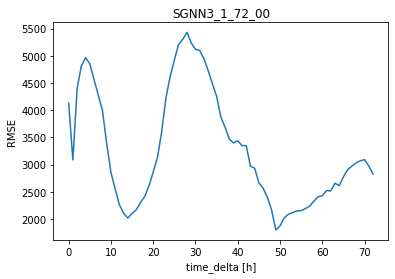

KeyboardInterrupt: 

In [12]:
for exp_name, exp in experiments.items():
# start_date = "2019-01-11 00:00:00"
# exp = Experiment.load("PM25 old run", gnn_experiment_path + "1_24/3/PM25_GNN/2021-03-31_14-37-28/09/", start_date, devices)
# exp = experiments["PM25_GNN_1_72_00"]

    rmse_totals = None
    possible_start_dates = exp.parsed_timestamps[0]
    for start_date in tqdm(possible_start_dates):
        preds = gnn_prep.transform_preds_back(exp.date_idx, exp.parsed_timestamps, exp.pred_npy, exp.devices, start_date)
        true = ground_truth.rename_axis(None)

        df = pd.merge(preds, true, how="left", left_on=["time", "device_id"], right_on=["time", "device_id"], suffixes=('_pred', '_true'))
        df["time_delta"] =(df["time"] - pd.to_datetime(start_date)) / np.timedelta64(1, 'h')
        df["rmse"] = (df['pm25_pred'] - df['pm25_true']) ** 2

        rmse_series = df.groupby('time_delta').mean()['rmse']
        if rmse_totals is None:
            rmse_totals = rmse_series.to_frame()
        else:
            rmse_totals = rmse_totals.join(rmse_series, rsuffix=start_date)
            # assert not rmse_totals.hasnans
        
    rmse_totals = rmse_totals.mean(1)

    x = list(rmse_totals.index)
    y = list(rmse_totals)

    plt.plot(x, y)
    plt.xlabel("time_delta [h]")
    plt.ylabel("RMSE")
    plt.title(exp_name)
    plt.show()

In [41]:
rmse_totals

time_delta
0.0     2598.008891
1.0             NaN
2.0             NaN
3.0             NaN
4.0             NaN
           ...     
68.0            NaN
69.0            NaN
70.0            NaN
71.0            NaN
72.0            NaN
Name: rmse, Length: 73, dtype: float64

In [ ]:
rmse_totals 

## Ensembles

In [ ]:
# ensemble_name = "SGNN3_0_168_ensemble"
# ensemble = ensemblify(experiments, ensemble_name)

# deep_ensemble_name = "SGNN3_0_168_deep_ensemble"
# experiments[deep_ensemble_name] = deep_ensemblify(experiments, deep_ensemble_name)
# experiments[ensemble_name] = ensemble

## Sankey diagram

In [ ]:
exp = experiments["SGNN3_0_168_00"]
start_time_idx = 0
pred_time_idx = 0
plot_threshold = 0.3 # plot only edges with an r_i higher than this threshold

In [ ]:
labels = exp.devices
R = exp.R_npy[start_time_idx, pred_time_idx]

target = list(itertools.chain(*[[i] * len(labels) for i in range(len(labels))]))
source = list(range(len(labels))) * len(labels)
values = list(R.flatten())

Filter according to threshold.

In [ ]:
target_filtered, source_filtered, values_filtered = [], [], []

for t, s, v in zip(target, source, values):
    if v > plot_threshold:
        target_filtered.append(t)
        source_filtered.append(s)
        values_filtered.append(v)

print(f"Plotting {len(source_filtered)} edges")

In [ ]:
colormap = px.colors.cyclical.IceFire
assert len(colormap) > len(labels), "Not enough colours for nodes"

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      label = labels,
      color = list(map(lambda i: colormap[i], range(len(labels)))),
      hoverinfo = 'none'
    ),
    link = dict(
      source = source_filtered,
      target = target_filtered,
      value = values_filtered,
      color = list(map(lambda i: colormap[i], source_filtered)),
      #hoverinfo = 'none'
  ))], layout={'width': 1200, 'height': 700})

fig.update_layout(font_size=10)
fig.show()

## New plotting

In [ ]:
exp = experiments["SGNN3_0-336_00"]
exp

In [ ]:
exp.devices

In [ ]:
time_df = pd.DataFrame(exp.time_npy).applymap(pd.Timestamp.fromtimestamp)

In [ ]:
exp.preds

In [ ]:
pred_df.melt(ignore_index=False, var_name='device_id', value_name='pm25')

In [ ]:
exp.pred_npy